In [1]:
import helper_functions as hf

import scipy.stats as stats
import sigfig as sf
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os

In [2]:
tfbsType='ETS'
tfName='ETS'

roundFc=True

In [3]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt

In [4]:
def ets(kmer4):
    if kmer4 in ['GGAA','GGAT','TTCC','ATCC']: return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2EtsLogic={
    (0,0):'Ets Never',
    (1,1):'Ets Always',
    (0,1):'Ets Created',
    (1,0):'Ets Deleted'
}

In [5]:
def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    etsChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        core   =kmer8[2:6]
        coremut=kmer8mut[2:6]

        ba=(ets(core),ets(coremut)) # before after logic
        etsLogic=BeforeAfter2EtsLogic[ba]

        # If ets-changing snp found, write it out
        if etsLogic=='Ets Always': 
            etsChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return etsLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif etsLogic=='Ets Created':
            return etsLogic,kmer8,kmer8mut
            
        elif etsLogic=='Ets Deleted':
            return etsLogic,kmer8,kmer8mut

    if etsChanged==False:
        return 'Variant not in ETS',kmer8,kmer8mut




# Load ref data

In [6]:

ref  =f'preprocessed-data/parsed_Ets1_8mers.txt'              
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)

AAAAAAAA 0.14700431859740803


In [7]:
# hg38
ref='/Users/joe/code/ref/genomes/human/hg38/fasta/hg38.fa'
chr2seq=hf.faLoadGenome(ref)

# Load MPRA data

In [8]:
fn='preprocessed-data//kircher-hg38-allens-nodels-correctPvals=True.tsv'
df=pd.read_csv(fn,sep='\t')
df.head(2)

,cse,chrom,pos,ref,alt,effect,p-value,Element
0,chr2_60494940_C_A,chr2,60494940,C,A,-0.05,0.591536,BCL11A
1,chr2_60494940_C_G,chr2,60494940,C,G,-0.13,0.289893,BCL11A


In [9]:

elementList=[]
variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt,element=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt','Element']]

    if alt=='-': alt=''
    resultList=snv_ets_analysis(chrom,pos,ref,alt,chr2seq,Seq2EtsAff)
    result=resultList[0]
    
    if result=='Variant not in ETS':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Ets')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        elementList.append(element)

    elif result=='Ets Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        elementList.append(element)

    elif result=='Ets Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Ets Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        elementList.append(element)
        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        
        if roundFc: fc=sf.round(fc,3)
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)
        elementList.append(element)
        
        
    

In [10]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist
df['element']=elementList

df['aff-delta']=df.apply(lambda row: row['aff-alt']-row['aff-ref'],axis=1)

In [11]:
# Replace 0 p value with lowest non-zero p observed since we log transform later
print('before filter:',df.sort_values('p-value')['p-value'].unique())

plist=df.sort_values('p-value')['p-value'].unique()
minP=plist[0]
minP2=plist[1]

print('\n\n',minP,minP2)

df['p-value']=df['p-value'].apply(lambda p: p if p>0 else minP2)

print('after filter:',df.sort_values('p-value')['p-value'].unique())

before filter: [0.00000000e+00 5.91037861e-05 1.14759028e-04 ... 9.99944793e-01
 9.99972397e-01 9.99990000e-01]


 0.0 5.910378607360339e-05
after filter: [5.91037861e-05 1.14759028e-04 1.68691436e-04 ... 9.99944793e-01
 9.99972397e-01 9.99990000e-01]


In [12]:
df['-log(p)']=df['p-value'].apply(lambda p: -np.log10(p))
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=0 else -r['-log(p)'],axis=1)

In [13]:
df['variant-type'].value_counts()

Not In Ets     32239
Ets Always      2550
Ets Created     2210
Ets Deleted     2171
Name: variant-type, dtype: int64

In [14]:
df.element.value_counts()

FOXE1            1800
BCL11A           1799
SORT1.2          1798
RET              1797
MYCrs6983267     1792
SORT1-flip       1791
SORT1            1790
IRF6             1785
MSMB             1773
TCF7L2           1770
UC88             1761
ZFAND3           1736
ZRSh-13          1455
ZRSh-13h2        1455
PKLR-48h         1407
PKLR-24h         1407
MYCrs11986220    1389
IRF4             1353
GP1BA            1154
LDLR.2            954
LDLR              954
F9                904
HNF4A             855
HBG1              822
TERT-GAa          777
TERT-GBM          777
TERT-GSc          777
TERT-HEK          777
HBB               561
Name: element, dtype: int64

# Nature boxes

In [15]:
enhancers11=['BCL11A',
'IRF4',
'IRF6',
'MYCrs11986220',
'MYCrs6983267',
'RET',
'TCF7L2',
'UC88',
'ZFAND3',
'SORT1',
'ZRSh-13h2']

In [16]:
zrsList=['ZRSh-13h2']

fcOptCutoff=1.59
fcDecCutoff=sf.round(1/fcOptCutoff,3)

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)

deNovoThresh=.15

pvalCutoff=.05
logSigCutoff=abs(np.log10(pvalCutoff))

for zrsList in [['ZRSh-13h2'],enhancers11]:
    
    print(zrsList)

    # get variants to predict on
    predDF=df.loc[df.Element.isin(zrsList),:]

    # assign prediction labels
    bins=[-np.inf,-logSigCutoff,logSigCutoff,np.inf]
    predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

    # assign predictions
    etsLabels=[]

    for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

        # not in tf
        if classification=='Not In Ets':
            anno='not-in-tf'

        # delet tf
        elif classification=='Ets Deleted':
            anno='del-tf'

        elif classification=='Ets Created':

            denovoaff=Seq2EtsAff[kmerMut]

            if denovoaff<deNovoThresh:
                anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

            elif denovoaff>=deNovoThresh:
                anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

        #  dramatic iincrase
        elif fc>=fcOptCutoff:
            anno=f'dramatic-increase\n>={fcOptCutoff}'
            
        #  dramatic incrase
        elif fc<=fcDecCutoff:
            # print(fc,classification)
            anno=f'dramatic-decrease\n<={fcDecCutoff}'

        # no increase
        elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
            anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'

        else:
            # print(fc,classification,kmer,kmerMut)
            anno='subtle-change'


        etsLabels.append(anno)

    predDF['tf-class']=etsLabels

    line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

    for classi in predDF['tf-class'].unique():
        nClassi=predDF['tf-class'].value_counts()[classi]

        ns,gof,lof=[predDF.loc[predDF['tf-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

        line_out+=hf.write_row([classi,nClassi,ns,gof,lof])

    print(line_out)
    zrsId='+'.join(zrsList)
    with open(f'FOR-NATURE-STATS-PREDICTIONS-{tfName}-{zrsId}__fdr.tsv','w') as f: f.write(line_out)

/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


['ZRSh-13h2']
snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	1136	839	170	127
de-novo-tf-low-aff
<0.15	52	41	4	7
de-novo-tf-high-aff
>=0.15	12	9	2	1
dramatic-decrease
<=0.629	29	25	2	2
subtle-change	28	22	2	4
no-change-aff
<=1.25
>=0.8	70	53	11	6
del-tf	117	92	16	9
dramatic-increase
>=1.59	11	7	4	0

['BCL11A', 'IRF4', 'IRF6', 'MYCrs11986220', 'MYCrs6983267', 'RET', 'TCF7L2', 'UC88', 'ZFAND3', 'SORT1', 'ZRSh-13h2']
snv-group	total	effect-ns	effect-gof	effect-lof
del-tf	1136	837	119	180
no-change-aff
<=1.25
>=0.8	852	634	96	122
subtle-change	269	197	30	42
not-in-tf	14924	10863	1716	2345
de-novo-tf-low-aff
<0.15	776	578	81	117
de-novo-tf-high-aff
>=0.15	241	157	51	33
dramatic-increase
>=1.59	124	88	27	9
dramatic-decrease
<=0.629	105	74	7	24



/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4374/3657405942.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])
/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4374/3657405942.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predDF['tf-class']=etsLabels
/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4374/3657405942.py:23: SettingWithCopyWarning: 
A v

['BCL11A', 'IRF4', 'IRF6', 'MYCrs11986220', 'MYCrs6983267', 'RET', 'TCF7L2', 'UC88', 'ZFAND3', 'SORT1', 'ZRSh-13h2']

[['not-in-tf', 'del-tf', 'dramatic-decrease\n<=0.629', 'de-novo-tf-low-aff\n<0.15', 'de-novo-tf-high-aff\n>=0.15', 'subtle-change'], ['no-change-aff\n<=1.25\n>=0.8'], ['dramatic-increase\n>=1.59']]

group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	no-change-aff <=1.25 >=0.8	0.1209
not-in-tf+del-tf+dramatic-decrease <=0.629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	dramatic-increase >=1.59	8.94e-06



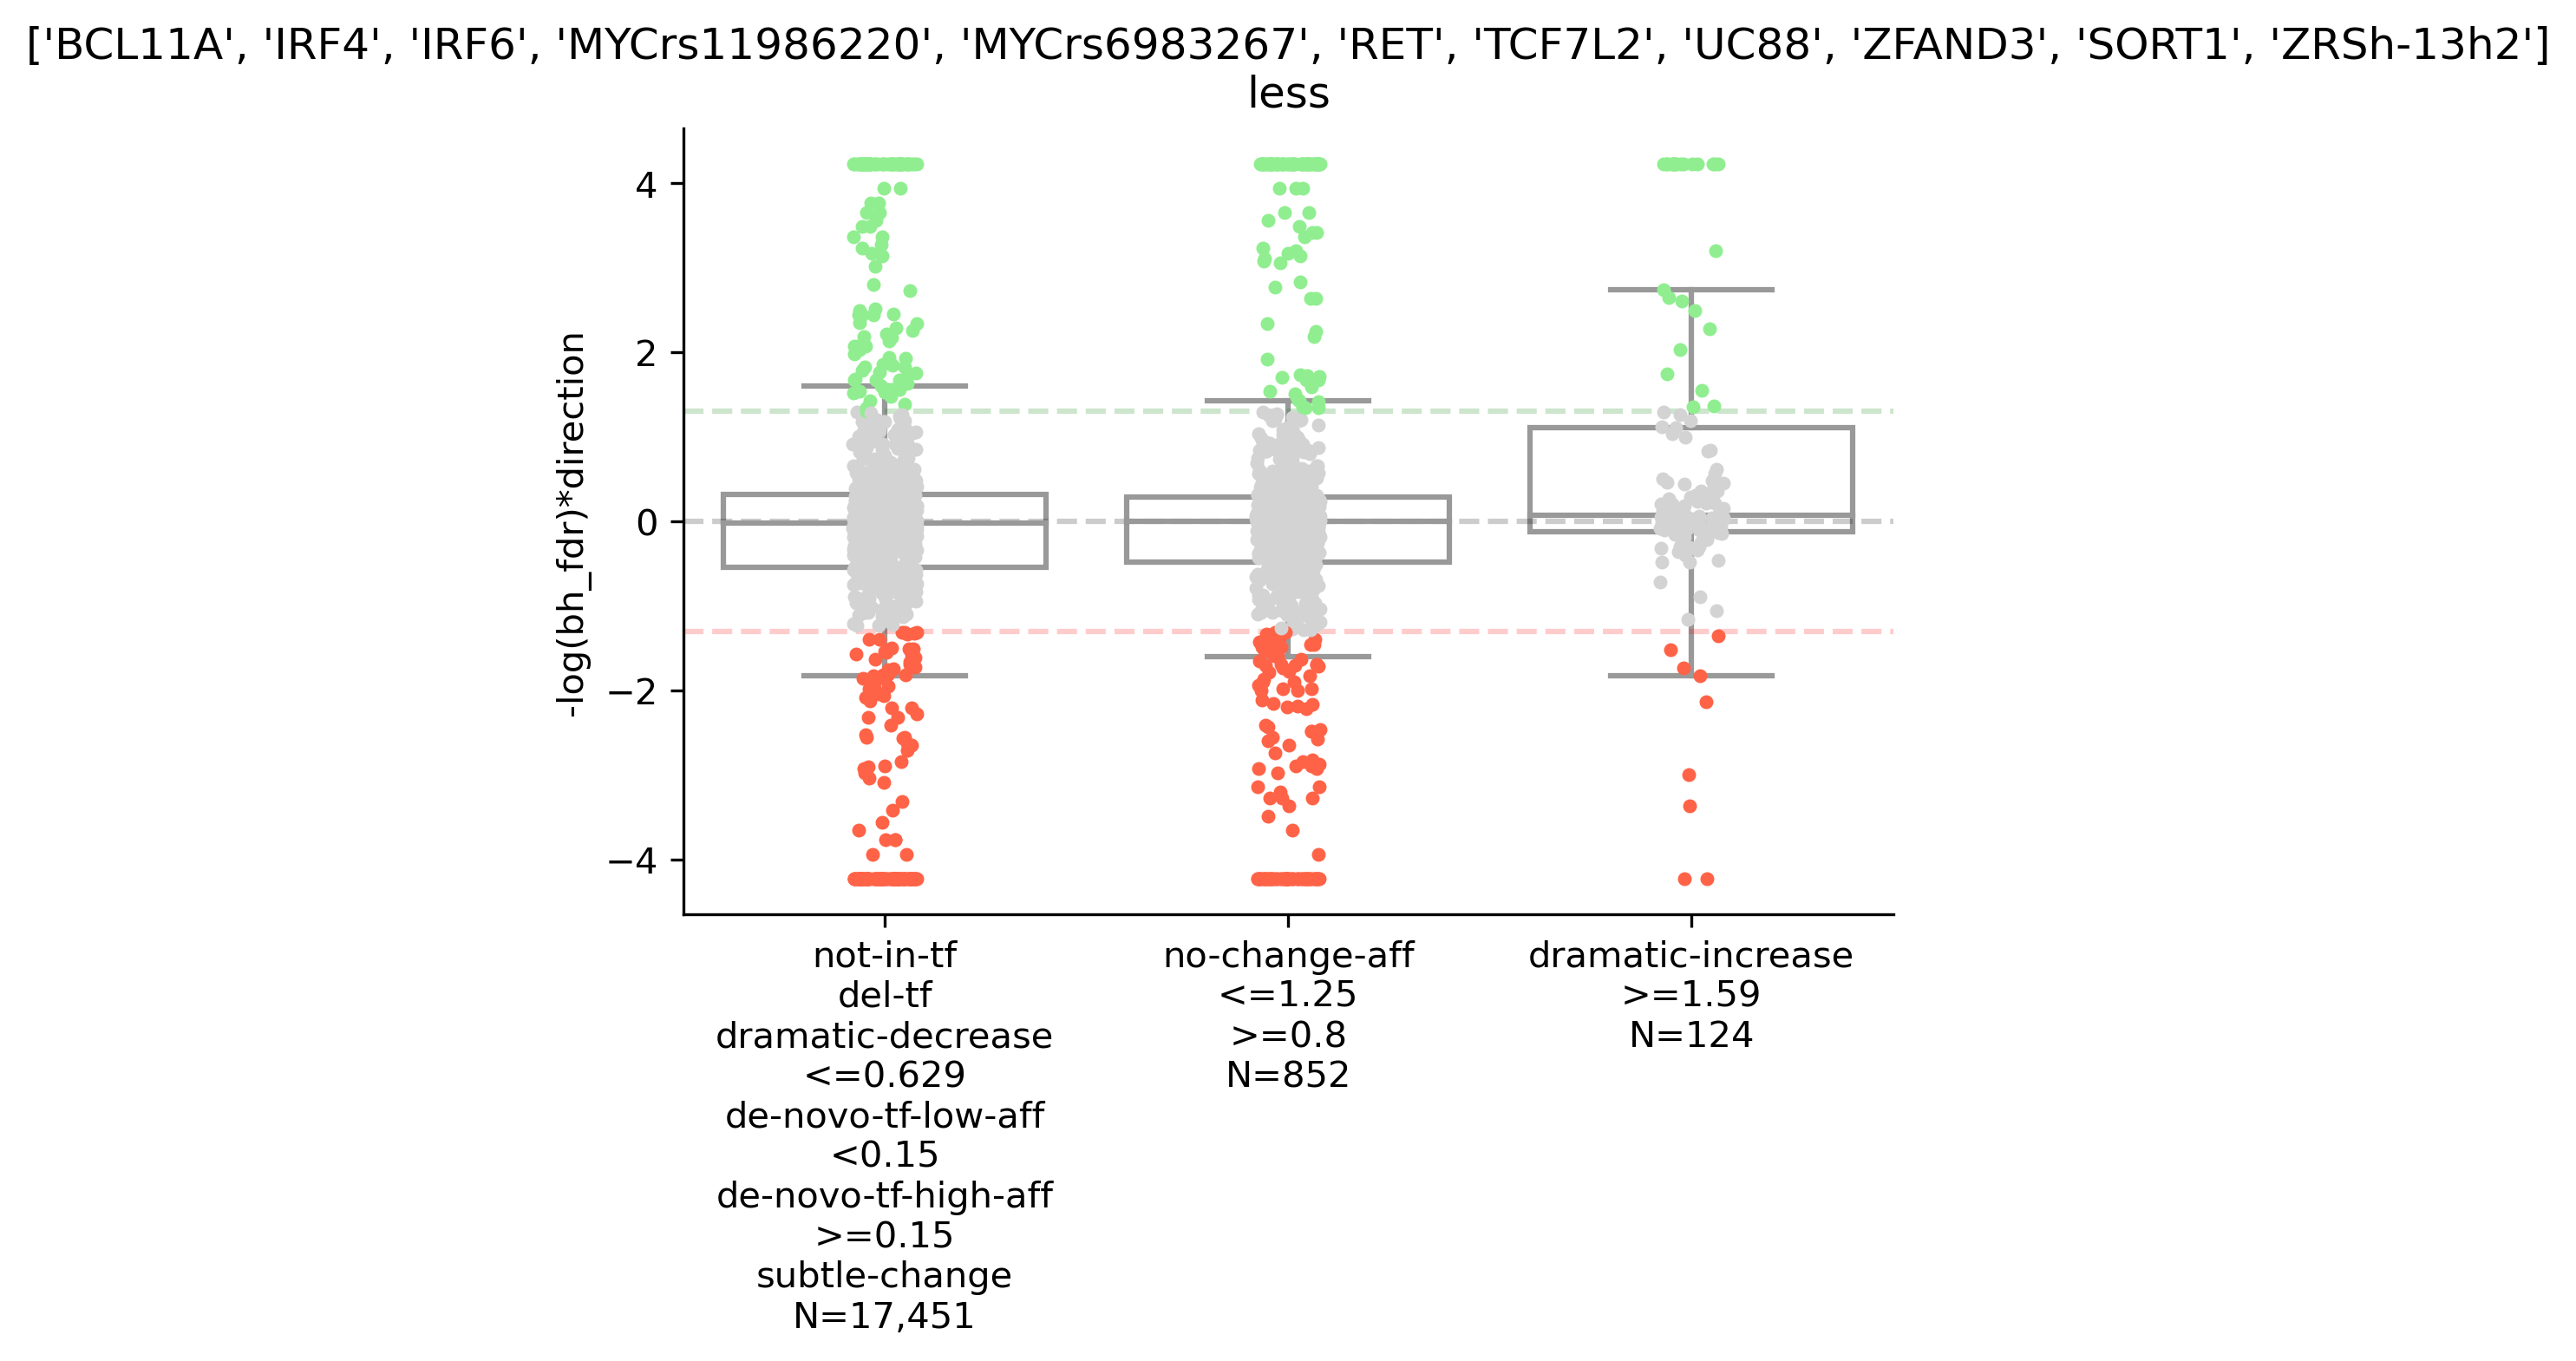

['ZRSh-13h2']

[['not-in-tf', 'del-tf', 'dramatic-decrease\n<=0.629', 'de-novo-tf-low-aff\n<0.15', 'de-novo-tf-high-aff\n>=0.15', 'subtle-change'], ['no-change-aff\n<=1.25\n>=0.8'], ['dramatic-increase\n>=1.59']]

group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	no-change-aff <=1.25 >=0.8	0.0568
not-in-tf+del-tf+dramatic-decrease <=0.629+de-novo-tf-low-aff <0.15+de-novo-tf-high-aff >=0.15+subtle-change	dramatic-increase >=1.59	0.01402



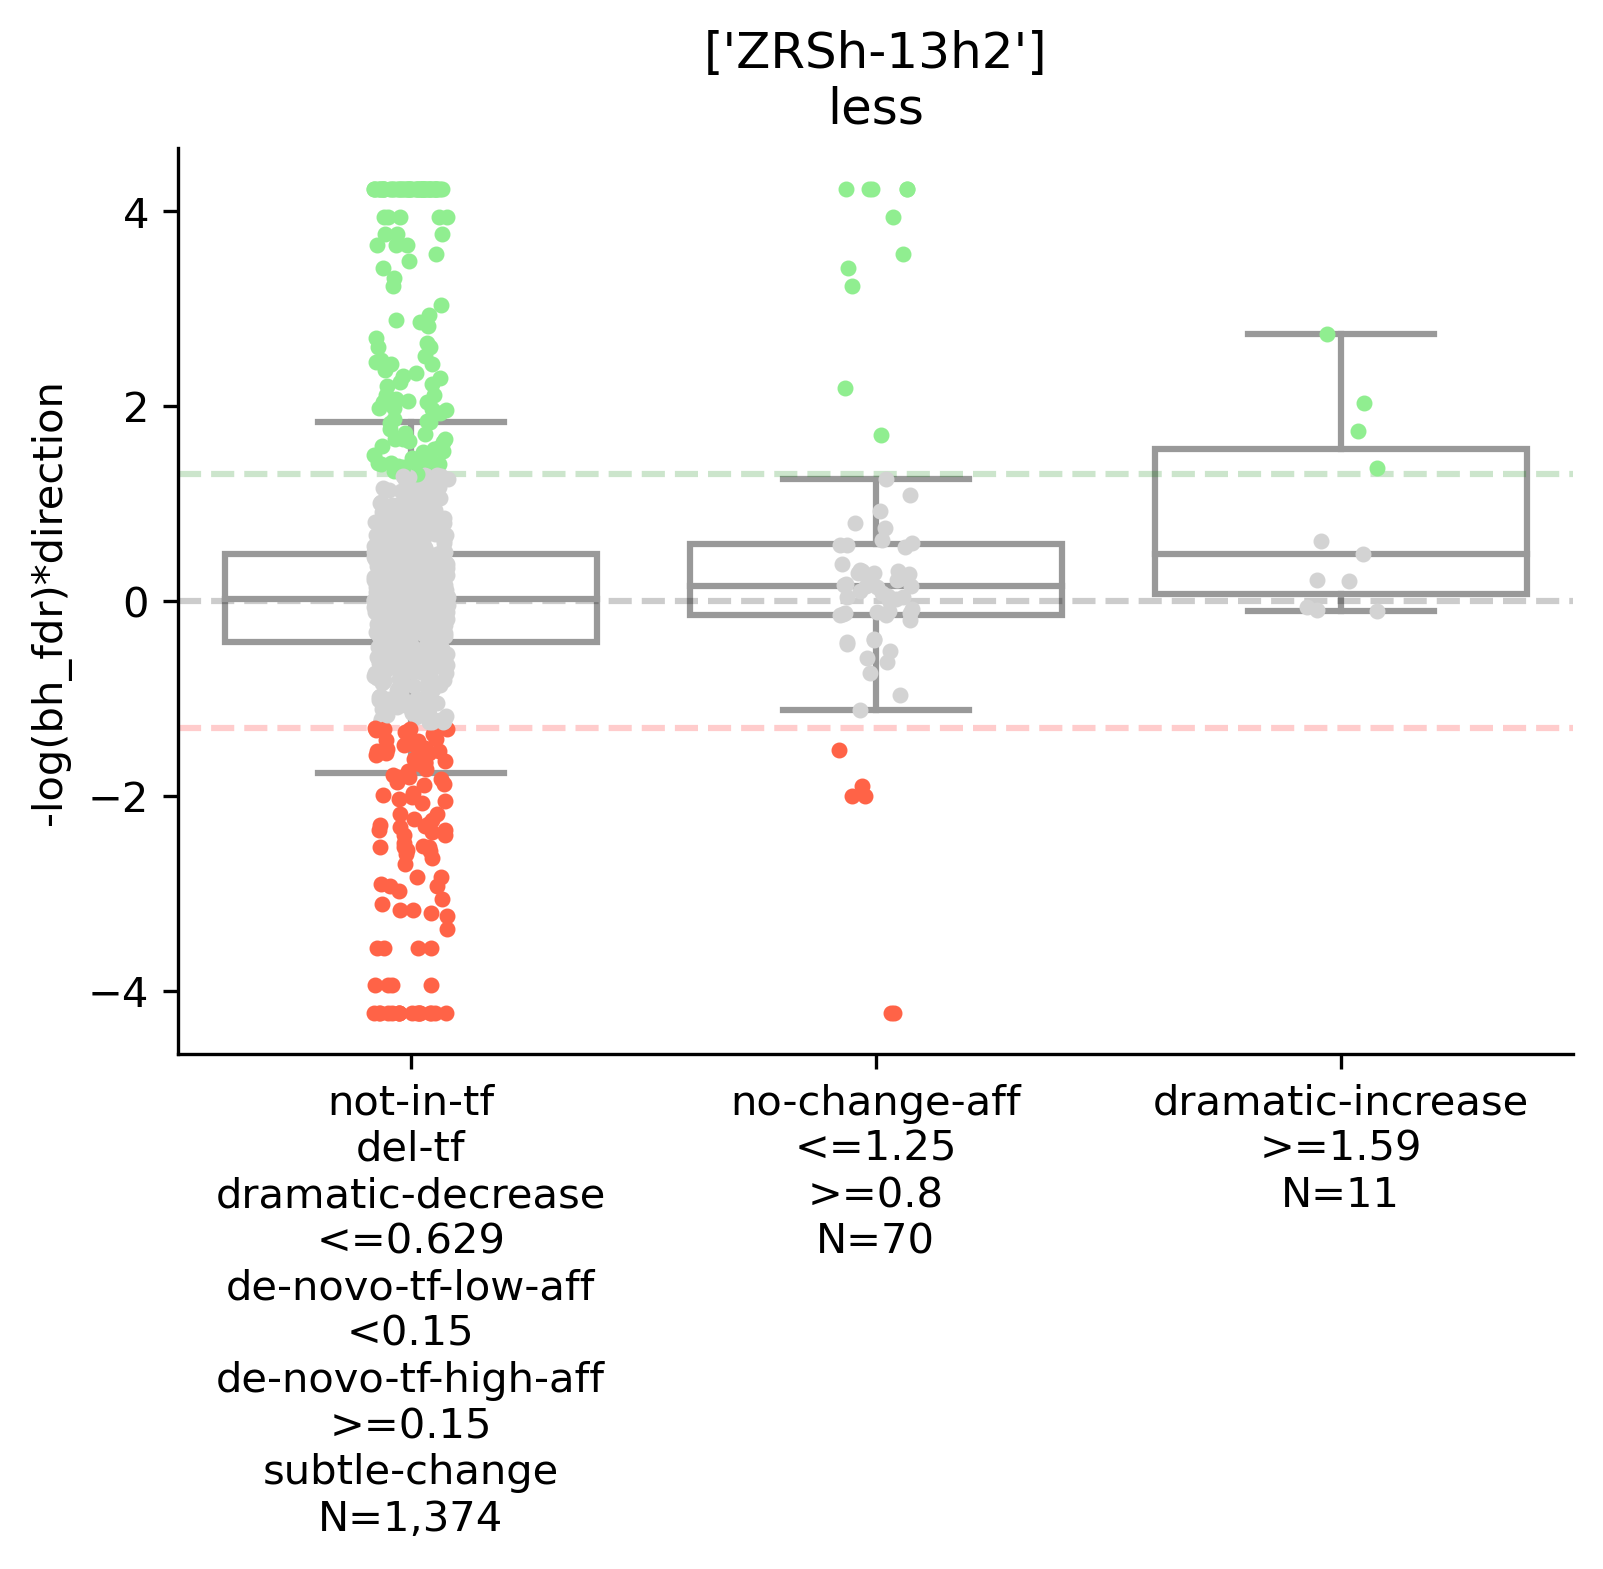

In [17]:
altHypothesis='less'

violin=False
boxplot=True
stackedBar=False

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}


for elementList in [enhancers11,['ZRSh-13h2']]:
    
    print(elementList)
    print()
            
    print(datalabels_subset_v2)
    print()

    plotDF=predDF.loc[predDF.Element.isin(elementList),:]
    # print(predDF.Element.unique())
    # print(len(plotDF))

    data=[]
    for di in datalabels_subset_v2:
        datai=[]
        for dj in di:
            datai+=plotDF.loc[(plotDF['tf-class']==dj),'-log(p)*direction'].tolist()
        data.append(datai)

    line_out=hf.write_row(['group1','group2','p'])

    ############################################################################
    # Stats
    ############################################################################

    dCtrlNameList=datalabels_subset_v2[0]
    dCtrl=plotDF.loc[(plotDF['tf-class'].isin(dCtrlNameList)),'-log(p)*direction']

    for diNameList in datalabels_subset_v2[1:]:

        di=plotDF.loc[(plotDF['tf-class'].isin(diNameList)),'-log(p)*direction']

        try:
            _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
        except ValueError:
            pass


        line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

    print(line_out)
    sampleName='+'.join(elementList)
    with open(f'FOR-NATURE__violin-stats__{tfName}__{sampleName}.tsv','w') as f: f.write(line_out)

    ############################################################################
    # Stats
    ############################################################################

    fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

    palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

    if violin:
        sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

    if boxplot:
        sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

    lc=0
    for xi,di in enumerate(data):
        random.shuffle(di)
        for lc, yi in enumerate(di):
            if lc>1000: break
            xjittermax=.08
            xijitter=np.random.uniform(-xjittermax,xjittermax)
            if yi>=logSigCutoff:            color='lightgreen'
            elif yi<=-logSigCutoff:          color='tomato'
            else:                           color='lightgrey'

            ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
    ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
    ax.set_ylabel('-log(bh_fdr)*direction')

    ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
    ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
    ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

    ax.set_title(f'{elementList}\n{altHypothesis}')

    idList='+'.join(elementList)

    plt.show()   

    plotDF.to_csv(f'NATURE-ALL-DATA_{tfName}_{idList}.tsv',sep='\t',index=None)
        